In [1]:
from mss import mss
import pyautogui
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy




In [67]:
# Create Enviroment

class WebGame(Env):
    
    # setup the enviroment action and observation shapes
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(4)
        # Capture game frames
        self.cap = mss()
        self.previous_score = 0
        self.game_location = {'top': 158, 'left': 0, 'width': 1469, 'height': 753}
        self.done_location = {'top': 594, 'left': 726, 'width': 100, 'height': 60}
        self.score_location = {'top': 200, 'left': 683, 'width': 160, 'height': 50}
    
    # call to do something
    def step(self, action):
        action_map = { 
            0: 'up',
            1: 'down',
            2: 'left',
            3: 'right'
        }
        pyautogui.keyDown(action_map[action])
        time.sleep(1)
        pyautogui.keyUp(action_map[action])
            
        done, done_cap = self.get_done()
        current_score, score_cap, score_res = self.get_score()
        
        if current_score is None:
            current_score = self.previous_score
        observation = self.get_observation()
        reward = self.calculate_reward(current_score, self.previous_score, done)  # Placeholder for reward calculation logic
        info = {}
        
        if current_score is not None:
            self.previous_score = current_score
        
        terminated = done
        truncated = False
        return observation, reward, terminated, truncated, info
    
    def calculate_reward(self, current_score, previous_score, game_over):
        reward = 1  # Reward for surviving each frame
        if game_over:
            # Apply a significant penalty if the game is over
            reward -= 20
        else:
            try:
                # Calculate score difference, if applicable
                score_difference = current_score - previous_score
                reward += score_difference
            except TypeError:
                # If scores are None or not integers, don't adjust the reward
                pass
        return reward

    
    
    # restart the game
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # If your environment inherits from gym.Env, you might need to call super().reset(seed=seed) to properly handle seeding.
        self.previous_score = 0
        time.sleep(1)
        pyautogui.click(x=755, y=618)  # Simulate mouse click at position (150, 300)
        time.sleep(1)
        pyautogui.click(x=704, y=455)
        observation = self.get_observation()
        return observation, {}  # Return observation and an empty info dictionary

    
    # get the part of the observation of the game
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel

    
    # get done text
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['OK']
        done=False
        res = pytesseract.image_to_string(done_cap, config='--psm 7 --oem 3 -l eng tessedit_char_whitelist=OK')[:2]
        if res in done_strings:
            done = True
        return done, done_cap
    
    def get_score(self):
        score_cap = np.array(self.cap.grab(self.score_location))
        ocr_config = '--psm 7 --oem 3 -c tessedit_char_whitelist=0123456789'
        res = pytesseract.image_to_string(score_cap, config=ocr_config)
        
        try:
            res = res.strip()
            if res in ['0', 'Oo', '0o']:
                score = 0
            else:
                score = int(res)
        except ValueError:
            score = None  # If OCR fails, return None
        
        return score, score_cap, res
    
    

In [65]:
env = WebGame()# Stack n frames

In [43]:
env.action_space.sample()

2

In [66]:
# Testing

for episode in range(10): 
    obs = env.reset()  # Adjusted to match the new reset signature
    terminated = False  # Initialize terminated flag
    truncated = False  # Initialize truncated flag
    total_reward = 0
    while not terminated and not truncated:  # Check both flags
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')


Total Reward for episode 0 is -10
Total Reward for episode 1 is -19
Total Reward for episode 2 is -18
Total Reward for episode 3 is -17


KeyboardInterrupt: 

In [68]:
# Callback

# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [51]:
env = WebGame()# Stack n frames

env_checker.check_env(env)

In [69]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [70]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [71]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)


In [55]:
# Build and Train DQN

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack


In [56]:
env = DummyVecEnv([lambda: WebGame()])
env = VecFrameStack(env, n_stack=4)

In [72]:
model = DQN(
    policy='CnnPolicy',
    env=env,
    learning_rate=1e-4,  # From the configuration
    buffer_size=25000,  # From the configuration
    learning_starts=400,  # From the configuration
    batch_size=32,  # From the configuration
    tau=1.0,  # Target network update rate, not specified in the configuration but often set to 1.0
    target_update_interval=1000,  # From the configuration
    train_freq=4,  # From the configuration
    gradient_steps=1,  # From the configuration
    exploration_fraction=0.1,  # Not directly applicable in stable_baselines3's DQN, manage exploration via epsilon decay
    exploration_initial_eps=1.0,  # Start exploration rate
    exploration_final_eps=0.01,  # From the configuration
    max_grad_norm=10,  # Not specified, but a common setting to prevent exploding gradients
    tensorboard_log=LOG_DIR,  # From the initial code snippet
    verbose=1,  # From the initial code snippet
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [73]:
model.learn(total_timesteps=10000, callback=callback)

Logging to ./logs/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | -13.2    |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 46       |
|    total_timesteps  | 15       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.38     |
|    ep_rew_mean      | -15.1    |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 0        |
|    time_elapsed     | 83       |
|    total_timesteps  | 27       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | -8.08    |
|    exploration_rate | 0.953    |
| time/               |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.47     |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.684    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 0        |
|    time_elapsed     | 961      |
|    total_timesteps  | 319      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.5      |
|    ep_rew_mean      | -14.1    |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 0        |
|    time_elapsed     | 1010     |
|    total_timesteps  | 336      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.45     |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.51     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.428    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 0        |
|    time_elapsed     | 1735     |
|    total_timesteps  | 578      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.85     |
|    n_updates        | 44       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.52     |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.41     |
| time/               |          |
|    episodes         | 168      |
|    fps              | 0        |
|    time_elapsed     | 1786     |
|    total_timesteps  | 596      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.159    |
| time/               |          |
|    episodes         | 228      |
|    fps              | 0        |
|    time_elapsed     | 2520     |
|    total_timesteps  | 849      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.62     |
|    n_updates        | 112      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | -12.1    |
|    exploration_rate | 0.144    |
| time/               |          |
|    episodes         | 232      |
|    fps              | 0        |
|    time_elapsed     | 2566     |
|    total_timesteps  | 865      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.85     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.29     |
|    ep_rew_mean      | -11.8    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 292      |
|    fps              | 0        |
|    time_elapsed     | 3277     |
|    total_timesteps  | 1108     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.23     |
|    n_updates        | 176      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 296      |
|    fps              | 0        |
|    time_elapsed     | 3298     |
|    total_timesteps  | 1113     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.89     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.21     |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 0        |
|    time_elapsed     | 4275     |
|    total_timesteps  | 1470     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 267      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.17     |
|    ep_rew_mean      | -12.6    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 360      |
|    fps              | 0        |
|    time_elapsed     | 4301     |
|    total_timesteps  | 1477     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.93     |
|    n_updates      

KeyboardInterrupt: 

In [20]:
#testout model

model = DQN.load("./train/best_model_84000.zip")

# Test out model:

for episode in range(5):  # Adjust the number of episodes if needed
    obs = env.reset()  # Adjusted to match the new reset signature
    terminated = False  # Initialize terminated flag
    truncated = False  # Initialize truncated flag
    total_reward = 0
    while not terminated and not truncated:  # Check both flags
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(int(action))
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')


/Users/suqingliu/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.66GB > 1.52GB
  warnings.warn(


TypeError: 'int' object is not subscriptable

In [ ]:
plt.imshow(env.get_score()[1])

In [180]:
env.get_score()[0]

36

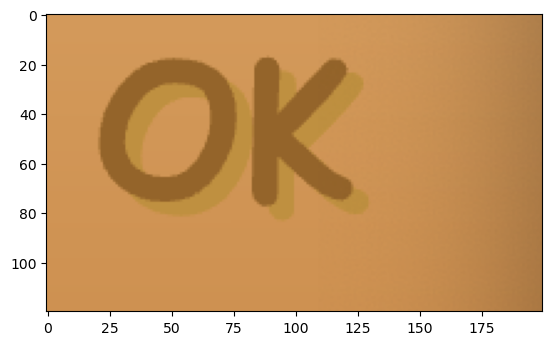

In [185]:
plt.imshow(env.get_done()[1])

In [186]:
env.get_done()[0]

True